In [1]:
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch

from tqdm import tqdm
from torch import optim
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration, BitsAndBytesConfig

## Loading Llava

In [2]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-vicuna-7b-hf", do_rescale=False)
model = LlavaNextForConditionalGeneration.from_pretrained("llava-hf/llava-v1.6-vicuna-7b-hf", torch_dtype=torch.float16, low_cpu_mem_usage=True, quantization_config=quantization_config)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
model.config.image_grid_pinpoints.append([336, 336])

## Defining adversarial perturbation training loop

In [4]:
def hard_to_soft_targets(hard_targets,num_classes=10):
  target_labels_hard = torch.Tensor(hard_targets).to(torch.long)
  target_labels_soft = torch.nn.functional.one_hot(target_labels_hard, num_classes=num_classes).to(torch.float).to("cuda")
  return target_labels_soft.detach().cpu().numpy()

def get_complex_specification_adversaries(
    attack_specifications,
    batch_size=32,
    lr=1e-1,
    optimizer_in=optim.SGD,
    attack_resolution=32,
    clip_images = True,
    steps=100,
    attack_Linfty_limit = None,
    stop_at_loss = None,
    verbose = True,
    flip_loss_sign = False,
  ):

  collect_images = []

  attack_specifications_prepared = []
  for (model, images, perturbation_ids, soft_targets) in attack_specifications:
    attack_specifications_prepared.append(
        (model,torch.Tensor(images).to("cuda"),perturbation_ids,torch.Tensor(soft_targets).to("cuda"))
        )

  # count how many perturbations are needed
  perturbation_count = max([max(specification[2]) for specification in attack_specifications]) + 1

  # perturbations
  image_perturbations = torch.Tensor(np.zeros((perturbation_count,3,attack_resolution,attack_resolution))).to("cuda")
  image_perturbations.requires_grad = True

  optimizer = optimizer_in([image_perturbations],lr=lr)

  if verbose:
    steps_bar = tqdm(range(steps), desc='Adversary progress', ncols=100)
  else:
    steps_bar = range(steps)

  for step in steps_bar:

    losses = []

    for (model, images, perturbation_ids, soft_targets) in attack_specifications_prepared:
      perturbations_to_use = image_perturbations[perturbation_ids]

      if attack_Linfty_limit is None:
        attacked_images = images + perturbations_to_use
      else:
        attacked_images = images + attack_Linfty_limit*torch.tanh(perturbations_to_use)

      if clip_images:
        attacked_images = torch.clip(attacked_images,0,1)

      #batching for the model
      batched_losses = []
      iterations = int(np.ceil(attacked_images.shape[0]/batch_size))
      for it in range(iterations):
        i1 = it*batch_size
        i2 = min([(it+1)*batch_size,attacked_images.shape[0]])

        input_image_tensor = torch.cat([attacked_images[i1:i2], attacked_images[i1:i2]])

        bos_token_embeds = model.get_input_embeddings()(processor.tokenizer(processor.tokenizer.bos_token, add_special_tokens=False, return_tensors='pt').input_ids).to(device)
        newline_embeds = model.get_input_embeddings()(processor.tokenizer('\n', add_special_tokens=False, return_tensors='pt').input_ids).to(device)

        image_features = model.vision_tower(input_image_tensor, output_hidden_states=True)
        selected_image_feature = image_features.hidden_states[-2]
        selected_image_feature = selected_image_feature[:, 1:]

        image_features = model.multi_modal_projector(selected_image_feature)
        image_features = image_features.reshape(-1, 4096)

        # Arush: This cat operation essentially returns the embeddings for "<s>[image_feature_embeddings]\n"

        text_image_embeds = torch.cat([bos_token_embeds, image_features.unsqueeze(0), newline_embeds], dim=1)
        outputs = model.language_model(
                  attention_mask=torch.ones(text_image_embeds.shape[1]),
                  position_ids=torch.arange(text_image_embeds.shape[1], dtype=torch.long, device=device).unsqueeze(0),
                  past_key_values=None,
                  inputs_embeds=text_image_embeds,
                  use_cache=None,
                  output_attentions=None,
                  output_hidden_states=None,
                  return_dict=True,
              )

        logits = outputs.logits
        loss = torch.nn.functional.cross_entropy(logits[0, -1].unsqueeze(0), soft_targets[i1:i2],reduction="none")
        with torch.no_grad():
          prob = torch.nn.functional.softmax(logits[0, -1])[soft_targets[i1:i2].argmax(1)].item()
        batched_losses.append(loss)

      if flip_loss_sign is False:
        torch.mean(torch.concatenate(batched_losses,axis=0)).backward()
      else:
        torch.mean(-torch.concatenate(batched_losses,axis=0)).backward()

      losses.append(torch.concatenate(batched_losses,axis=0).detach().cpu().numpy())

    overall_loss = np.mean(np.stack(losses))

    if verbose:
      steps_bar.set_description(f"loss = {overall_loss}, prob = {prob}")

    if stop_at_loss is not None and ((overall_loss <= stop_at_loss and flip_loss_sign is False) or (overall_loss >= stop_at_loss and flip_loss_sign is True)):
      # getting the resulting images
      if attack_Linfty_limit is None:
        return image_perturbations.detach().cpu().numpy()
      else:
        return attack_Linfty_limit*torch.tanh(image_perturbations).detach().cpu().numpy()


    optimizer.step()
    optimizer.zero_grad()

    collect_images.append(
      attacked_images
    )

  # getting the resulting images
  if attack_Linfty_limit is None:
    return image_perturbations.detach().cpu().numpy(), collect_images
  else:
    return attack_Linfty_limit*torch.tanh(image_perturbations).detach().cpu().numpy(), collect_images

In [5]:
device='cuda'
target_token = 'cat'
target_token_ids = processor.tokenizer(target_token, return_tensors="pt", add_special_tokens=False).input_ids.to(device).squeeze()

soft_target = hard_to_soft_targets([target_token_ids.item()], num_classes=32064)
soft_target.shape

(1, 32064)

## Generating perturbation without augmentations

In [6]:
init_input = np.ones((1, 3, 336, 336)) * 0.5
perturbation_id = [0]

In [7]:
attack_specification = [
  (
        model.eval(),
        init_input, # Single uniform gray image
        perturbation_id, # different perturbation id for each image = an attack per image
        soft_target, # Previously defined soft target
  ),
]

In [8]:
batch_size = 32
size = 336

results = get_complex_specification_adversaries(
    attack_specification,
    steps=400,
    batch_size=batch_size, #if you have cude problems, you can decrease this => less memory but slower
    attack_Linfty_limit=size/255,
    lr=1e-1,#2e-1,#*6,#1e0 if layer < 5 else 1e-1,
    stop_at_loss=1e-2,
    attack_resolution=336,
)

Adversary progress:   0%|                                                   | 0/400 [00:00<?, ?it/s]We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)
/var/tmp/ipykernel_17675/3899779174.py:93: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = torch.nn.functional.softmax(logits[0, -1])[soft_targets[i1:i2].argmax(1)].item()
loss = 0.00995976384729147, prob = 0.9900896549224854:  58%|███▌  | 234/400 [01:16<00:54,  3.05it/s]


In [9]:
if len(results) == 2:
  results = results[0]

perturbed_image = np.clip(init_input.transpose(0,2,3,1) + results.transpose([0,2,3,1]),0,1)

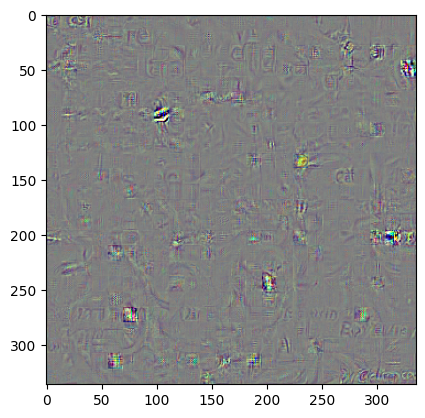

In [10]:

plt.imshow(perturbed_image[0])

## Defining augmentations and multi-resolution stack function

In [6]:
def apply_transformations(
    images,
    down_res = 224,
    up_res = 224,
    jit_x = 0,
    jit_y = 0,
    down_noise = 0.0,
    up_noise = 0.0,
    contrast = 1.0,
    color_amount = 1.0,
    ):

  # # for MNIST alone
  # images = torch.mean(images,axis=1,keepdims=True)

  images_collected = []

  for i in range(images.shape[0]):

    image = images[i]

    # changing contrast
    image = torchvision.transforms.functional.adjust_contrast(image, contrast[i])

    # shift the result in x and y
    image = torch.roll(image,shifts=(jit_x[i], jit_y[i]),dims=(-2,-1))

    # shifting in the color <-> grayscale axis
    image = color_amount[i]*image + torch.mean(image,axis=0,keepdims=True)*(1-color_amount[i])

    images_collected.append(image)

  images = torch.stack(images_collected, axis=0)

  # descrease the resolution
  images = F.interpolate(images, size=(down_res,down_res), mode='bicubic')

  # low res noise
  noise = down_noise * custom_rand(images+312, (images.shape[0],3,down_res,down_res)).to("cuda")
  images = images + noise

  # increase the resolution
  images = F.interpolate(images, size=(up_res,up_res), mode='bicubic')

  # high res noise
  noise = up_noise * custom_rand(images+812,(images.shape[0],3,up_res,up_res)).to("cuda")
  images = images + noise

  # clipping to the right range of values
  images = torch.clip(images,0,1)

  return images


# to be able to replace the random number generator by other things if needed
def custom_rand(input_tensor, size):
    return torch.Tensor(
        np.random.rand(*size)
    ).to("cuda")

def custom_choices(items, tensor):
  return np.random.choice(items,(len(tensor)))


def default_make_multichannel_input(images):
  return torch.concatenate([images]*len(resolutions),axis=1)

def make_multichannel_input(images,
                            contrast = 1.0,
                            up_res = 32, # hard coded for CIFAR-10 or CIFAR-100
                            ):

  all_channels = []

  for i,r in enumerate(resolutions):

    down_res = r

    jits_x = custom_choices(range(-jit_size,jit_size+1), images+i) # x-shift
    jits_y = custom_choices(range(-jit_size,jit_size+1), 51*images+7*i+125*r) # y-shift
    contrasts = custom_choices(np.linspace(0.7,1.5,100), 7+3*images+9*i+5*r) # change in contrast
    color_amounts = contrasts = custom_choices(np.linspace(0.5,1.0,100), 5+7*images+8*i+2*r) # change in color amount

    images_now = apply_transformations(
      images,
      down_res = down_res,
      up_res = up_res,
      jit_x = jits_x,
      jit_y = jits_y,
      down_noise = down_noise,
      up_noise = up_noise,
      contrast = contrasts,
      color_amount = color_amounts,
      )

    all_channels.append(images_now)

  if not shuffle_image_versions_randomly:
    return torch.concatenate(all_channels,axis=1)
  elif shuffle_image_versions_randomly:
    indices = torch.randperm(len(all_channels))
    shuffled_tensor_list = [all_channels[i] for i in indices]
    return torch.concatenate(shuffled_tensor_list,axis=1)

## Re-defining adversarial perturbation generation loop with added augmentions

In [7]:
def hard_to_soft_targets(hard_targets,num_classes=10):
  target_labels_hard = torch.Tensor(hard_targets).to(torch.long)
  target_labels_soft = torch.nn.functional.one_hot(target_labels_hard, num_classes=num_classes).to(torch.float).to("cuda")
  return target_labels_soft.detach().cpu().numpy()

def blur(x, ks=3, sigma=1):
    ks = ks if ks % 2 != 0 else ks + 1
    b = torchvision.transforms.GaussianBlur(ks, sigma=(sigma))
    return b(x)

def get_complex_specification_adversaries(
    attack_specifications,
    batch_size=32,
    lr=1e-1,
    optimizer_in=optim.SGD,
    attack_resolution=32,
    clip_images = True,
    steps=100,
    attack_Linfty_limit = None,
    stop_at_loss = None,
    verbose = True,
    flip_loss_sign = False,
  ):

  collect_images = []

  attack_specifications_prepared = []
  for (model, images, perturbation_ids, soft_targets) in attack_specifications:
    attack_specifications_prepared.append(
        (model,torch.Tensor(images).to("cuda"),perturbation_ids,torch.Tensor(soft_targets).to("cuda"))
        )

  # count how many perturbations are needed
  perturbation_count = max([max(specification[2]) for specification in attack_specifications]) + 1

  # perturbations
  image_perturbations = torch.Tensor(np.zeros((perturbation_count,3,attack_resolution,attack_resolution))).to("cuda")
  image_perturbations.requires_grad = True

  optimizer = optimizer_in([image_perturbations],lr=lr)

  if verbose:
    steps_bar = tqdm(range(steps), desc='Adversary progress', ncols=100)
  else:
    steps_bar = range(steps)

  max_ks = 336
  min_ks = 1
  all_ks = np.geomspace(max_ks, min_ks, steps, endpoint=True, dtype=np.int32)
  all_ks[all_ks % 2 == 0] -= 1

  for step in steps_bar:

    losses = []

    for (model, images, perturbation_ids, soft_targets) in attack_specifications_prepared:
      perturbations_to_use = image_perturbations[perturbation_ids]

      if attack_Linfty_limit is None:
        attacked_images = images + perturbations_to_use
      else:
        attacked_images = images + attack_Linfty_limit*torch.tanh(perturbations_to_use)

      ### Arush: This is the part where the image is augmented
      jits_x = np.random.choice(range(-jit_size,jit_size+1), 1)
      jits_y = np.random.choice(range(-jit_size,jit_size+1), 1) # y-shift
      contrasts = np.random.choice(np.linspace(0.7,1.5,100), 1) # change in contrast
      color_amounts = np.random.choice(np.linspace(0.5,1.0,100), 1) # change in color amount

      attacked_images_augmented = apply_transformations(attacked_images, up_res=336, jit_x=jits_x, jit_y=jits_y, contrast=contrasts, color_amount=color_amounts)

      # attacked_images_augmented = torchvision.transforms.RandomResizedCrop([168, 168], scale=(0.6,0.8), ratio=(1, 1), antialias=True)(attacked_images)
      attacked_images_augmented = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))(attacked_images_augmented)
      
      if clip_images:
        attacked_images_augmented = torch.clip(attacked_images_augmented,0,1)

      #batching for the model
      batched_losses = []
      iterations = int(np.ceil(attacked_images_augmented.shape[0]/batch_size))
      for it in range(iterations):
        i1 = it*batch_size
        i2 = min([(it+1)*batch_size,attacked_images_augmented.shape[0]])

        input_image_tensor = torch.cat([attacked_images_augmented[i1:i2], attacked_images_augmented[i1:i2]])

        bos_token_embeds = model.get_input_embeddings()(processor.tokenizer(processor.tokenizer.bos_token, add_special_tokens=False, return_tensors='pt').input_ids).to(device)
        newline_embeds = model.get_input_embeddings()(processor.tokenizer('\n', add_special_tokens=False, return_tensors='pt').input_ids).to(device)

        image_features = model.vision_tower(input_image_tensor, output_hidden_states=True)
        selected_image_feature = image_features.hidden_states[-2]
        selected_image_feature = selected_image_feature[:, 1:]

        image_features = model.multi_modal_projector(selected_image_feature)
        image_features = image_features.reshape(-1, 4096)

        # Arush: This cat operation essentially returns the embeddings for "<s>[image_feature_embeddings]\n"

        text_image_embeds = torch.cat([bos_token_embeds, image_features.unsqueeze(0), newline_embeds], dim=1)
        outputs = model.language_model(
                  attention_mask=torch.ones(text_image_embeds.shape[1]),
                  position_ids=torch.arange(text_image_embeds.shape[1], dtype=torch.long, device=device).unsqueeze(0),
                  past_key_values=None,
                  inputs_embeds=text_image_embeds,
                  use_cache=None,
                  output_attentions=None,
                  output_hidden_states=None,
                  return_dict=True,
              )

        logits = outputs.logits
        loss = torch.nn.functional.cross_entropy(logits[0, -1].unsqueeze(0), soft_targets[i1:i2],reduction="none")
        with torch.no_grad():
          prob = torch.nn.functional.softmax(logits[0, -1])[soft_targets[i1:i2].argmax(1)].item()
        batched_losses.append(loss)

      if flip_loss_sign is False:
        torch.mean(torch.concatenate(batched_losses,axis=0)).backward()
      else:
        torch.mean(-torch.concatenate(batched_losses,axis=0)).backward()

      losses.append(torch.concatenate(batched_losses,axis=0).detach().cpu().numpy())

    overall_loss = np.mean(np.stack(losses))

    # image_perturbations.grad = blur(input.grad, ks=all_ks[step-1], sigma=all_ks[step-1]/6)

    if verbose:
      steps_bar.set_description(f"loss = {overall_loss}, prob = {prob}")

    if stop_at_loss is not None and ((overall_loss <= stop_at_loss and flip_loss_sign is False) or (overall_loss >= stop_at_loss and flip_loss_sign is True)):
      # getting the resulting images
      if attack_Linfty_limit is None:
        return image_perturbations.detach().cpu().numpy()
      else:
        return attack_Linfty_limit*torch.tanh(image_perturbations).detach().cpu().numpy()


    optimizer.step()
    optimizer.zero_grad()

    collect_images.append(
      attacked_images
    )

  # getting the resulting images
  if attack_Linfty_limit is None:
    return image_perturbations.detach().cpu().numpy(), collect_images
  else:
    return attack_Linfty_limit*torch.tanh(image_perturbations).detach().cpu().numpy(), collect_images

In [10]:
batch_size = 32
size = 336

init_input = np.ones((1, 3, 336, 336)) * 0.5
perturbation_id = [0]

resolutions = [32,16,8,4] # pretty arbitrary
down_noise = 0.2 # noise standard deviation to be added at the low resolution
up_noise = 0.2 # noise stadard deviation to be added at the high resolution
jit_size = 3 # max size of the x-y jit in each axis, sampled uniformly from -jit_size to +jit_size inclusive

# to shuffle randomly which image is which in the multi-res stack
# False for all experiments in the paper, good for ablations
shuffle_image_versions_randomly = False

attack_specification = [
  (
        model.eval(),
        init_input, # Single uniform gray image
        perturbation_id, # different perturbation id for each image = an attack per image
        soft_target, # Previously defined soft target
  ),
]

results = get_complex_specification_adversaries(
    attack_specification,
    steps=10000,
    batch_size=batch_size, #if you have cude problems, you can decrease this => less memory but slower
    attack_Linfty_limit=size/255,
    lr=1e-1,#2e-1,#*6,#1e0 if layer < 5 else 1e-1,
    stop_at_loss=1e-2,
    attack_resolution=336,
)

Adversary progress:   0%|                                                 | 0/10000 [00:00<?, ?it/s]/var/tmp/ipykernel_30581/1407194107.py:114: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = torch.nn.functional.softmax(logits[0, -1])[soft_targets[i1:i2].argmax(1)].item()
loss = 0.009637967683374882, prob = 0.9904083013534546:  73%|█▍| 7326/10000 [39:10<14:17,  3.12it/s]


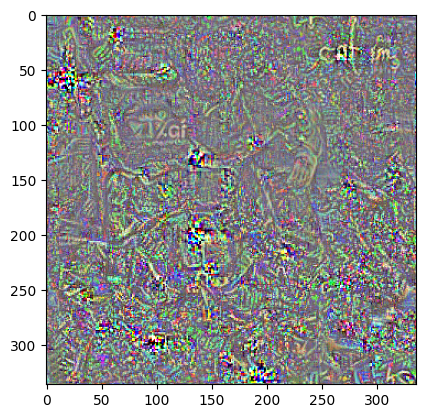

In [28]:
if len(results) == 2:
  results = results[0]

perturbed_image = np.clip(init_input.transpose(0,2,3,1) + results.transpose([0,2,3,1]),0,1)
plt.imshow(perturbed_image[0])

## Checking attack succes

### Mimicing training setup

In [24]:
perturbed_image = torch.from_numpy(perturbed_image.transpose(0,3,1,2)).to(device)
perturbed_image_patches = torch.cat([perturbed_image, perturbed_image])

bos_token_embeds = model.get_input_embeddings()(processor.tokenizer(processor.tokenizer.bos_token, add_special_tokens=False, return_tensors='pt').input_ids).to(device)
newline_embeds = model.get_input_embeddings()(processor.tokenizer('\n', add_special_tokens=False, return_tensors='pt').input_ids).to(device)

image_features = model.vision_tower(perturbed_image_patches, output_hidden_states=True)
selected_image_feature = image_features.hidden_states[-2]
selected_image_feature = selected_image_feature[:, 1:]

image_features = model.multi_modal_projector(selected_image_feature)
image_features = image_features.reshape(-1, 4096)

text_image_embeds = torch.cat([bos_token_embeds, image_features.unsqueeze(0), newline_embeds], dim=1)

output = model.language_model.generate(inputs_embeds=text_image_embeds, max_new_tokens=1)
processor.tokenizer.decode(output[0])

'cat'

In [25]:
output = model.language_model.generate(inputs_embeds=text_image_embeds, max_new_tokens=10)
processor.tokenizer.decode(output[0])

'cat cat cat cat cat cat cat cat cat cat'

### Using image as input to the processing pipeline

In [34]:
pixel_values = processor.image_processor(torch.from_numpy(perturbed_image.transpose(0,3,1,2)[0]), return_tensors='pt').pixel_values
prompt = '<image>\n'
input_ids = processor.tokenizer(prompt, add_special_tokens=True, return_tensors='pt').input_ids.to(device)

output = model.generate(pixel_values=pixel_values, input_ids=input_ids, image_sizes=[(336, 336)], max_new_tokens=50, attention_mask = torch.ones_like(input_ids))

processor.tokenizer.decode(output[0])
#processor.tokenizer.decode(torch.argmax(output.logits[0, -1, :]))

'<s><image>\n nobody is going to read this\nThis is a picture of a cat.</s>'

## Checking language transfer

In [37]:
image_features = model.vision_tower(torch.from_numpy(perturbed_image.transpose(0,3,1,2)), output_hidden_states=True)
selected_image_feature = image_features.hidden_states[-2]
selected_image_feature = selected_image_feature[:, 1:]
image_features = model.multi_modal_projector(selected_image_feature)

image_features = image_features.reshape(-1, 4096)

token_ids = (image_features @ model.get_input_embeddings().weight.T)

In [38]:
token_ids.shape

torch.Size([576, 32064])

In [43]:
max_tokens = token_ids.argmax(1)
processor.tokenizer.decode(max_tokens)

'greyosp upper utterUTν upperνタlyph光角 littüappa sweetappaappa Stern都Хν upperタ GreyМч hands resid RC RC RC�ч deliber rs person utterч少赤경Catנgommu javchrome花角 RC花ская RCü RC utter resid argentч person rsorumcket光cb cat catcm微мов sweet角花角 utter diagonal RC Pav男 Durante upperüчч少 rsч diagonalaines�ς sweetどŋ sweet rs花 RC utter Pav Pav角 busyская�少花 littч赤 rgчimeterч_*ч upper encryption️ская Pav litt ready경tero RC logoタч ready person hinterч少少ч� upper upper少 rg rgifulч경 RCч utter logo logoaudchev readyphabet nepчч Gray少 diagn hinter Centuryч littчizaław向 colorsская向加 triangle VIIurable gain合 hinterская hinterλバastern upper hintervtччactoryiza pity rgangles \xa0 RC chrome litt logo logotcpczelyphλanglesanglesλ familiarν nep景чckoitime pityifady upperlyph RC Pav \xa0 hinterч hinter \xa0 littλλλ rg Mason \xa0 dirtyغ rsч百花 upper경 rg少 colors släktetactory ready nep Pav ready RC mad ready角 readyν handslyph Grayччvt花othyaineч utteriza \xa0 utter hinteranglesч RCiza nep起ччambalyphч来чixon outputsчchrom

In [76]:
unique_tokens, counts_per_token = np.unique(max_tokens.cpu().numpy(), return_counts=True)

# Print a nicely formatted table with the token strings and descending order of counts

pd.set_option('display.max_rows', 200)

token_strings = processor.tokenizer.convert_ids_to_tokens(unique_tokens)
token_counts = counts_per_token

df = pd.DataFrame({'Token': token_strings, 'Count': token_counts})
df.sort_values('Count', ascending=False, inplace=True)
df.reset_index(drop=True, inplace=True)
df

,Token,Count
0,ч,71
1,▁utter,21
2,▁upper,20
3,▁RC,16
4,▁litt,15
5,▁ready,14
6,▁mad,14
7,▁,13
8,ская,12
9,ं,11


## Checking outputs from max_tokens

In [57]:
embeddings = model.get_input_embeddings().weight[max_tokens]

text_image_embeds = torch.cat([bos_token_embeds, embeddings.unsqueeze(0), newline_embeds], dim=1)

output = model.language_model.generate(inputs_embeds=text_image_embeds, max_new_tokens=50)
processor.tokenizer.decode(output[0])

'\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n'

In [77]:
output_tokens = model.language_model.generate(input_ids=max_tokens.unsqueeze(0), max_new_tokens=50)
processor.tokenizer.decode(output_tokens[0])[len(processor.tokenizer.decode(max_tokens)):]

' City Missouri United States North America USA North America South America Central America Caribbean Europe Asia Africa Middle East North Africa South Africa East Africa Central Africa West Africa North Africa South Africa East Africa South Africa North Africa South Africa East Africa South Africa North Africa South'

## Increasing jitter

In [74]:
batch_size = 32
size = 336

init_input = np.ones((1, 3, 336, 336)) * 0.5
perturbation_id = [0]

resolutions = [32,16,8,4] # pretty arbitrary
down_noise = 0.2 # noise standard deviation to be added at the low resolution
up_noise = 0.2 # noise stadard deviation to be added at the high resolution
jit_size = 168 # max size of the x-y jit in each axis, sampled uniformly from -jit_size to +jit_size inclusive

# to shuffle randomly which image is which in the multi-res stack
# False for all experiments in the paper, good for ablations
shuffle_image_versions_randomly = False

attack_specification = [
  (
        model.eval(),
        init_input, # Single uniform gray image
        perturbation_id, # different perturbation id for each image = an attack per image
        soft_target, # Previously defined soft target
  ),
]

input_image_tensor = get_complex_specification_adversaries(
    attack_specification,
    steps=10000,
    batch_size=batch_size, #if you have cude problems, you can decrease this => less memory but slower
    attack_Linfty_limit=size/255,
    lr=1e-1,#2e-1,#*6,#1e0 if layer < 5 else 1e-1,
    stop_at_loss=1e-2,
    attack_resolution=336,
)

Adversary progress:   0%|                                                 | 0/10000 [00:00<?, ?it/s]/var/tmp/ipykernel_17675/3259119594.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = torch.nn.functional.softmax(logits[0, -1])[soft_targets[i1:i2].argmax(1)].item()
loss = 0.35157257318496704, prob = 0.7035807967185974: 100%|██| 10000/10000 [54:03<00:00,  3.08it/s]


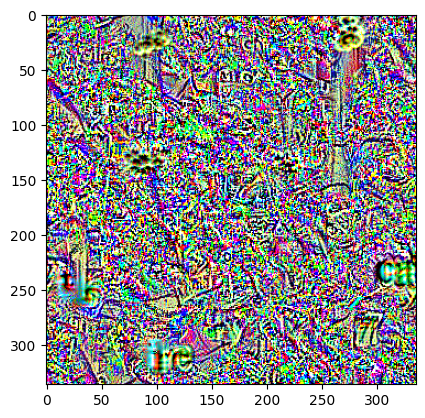

In [77]:
perturbed_image = np.clip(init_input.transpose(0,2,3,1) + input_image_tensor[0].transpose([0,2,3,1]),0,1)
plt.imshow(perturbed_image[0])

## Redefining adversarial perturbation loop to add in description statement

In [ ]:
def hard_to_soft_targets(hard_targets,num_classes=10):
  target_labels_hard = torch.Tensor(hard_targets).to(torch.long)
  target_labels_soft = torch.nn.functional.one_hot(target_labels_hard, num_classes=num_classes).to(torch.float).to("cuda")
  return target_labels_soft.detach().cpu().numpy()

def get_complex_specification_adversaries(
    attack_specifications,
    batch_size=32,
    lr=1e-1,
    optimizer_in=optim.SGD,
    attack_resolution=32,
    clip_images = True,
    steps=100,
    attack_Linfty_limit = None,
    stop_at_loss = None,
    verbose = True,
    flip_loss_sign = False,
  ):

  collect_images = []

  attack_specifications_prepared = []
  for (model, images, perturbation_ids, soft_targets) in attack_specifications:
    attack_specifications_prepared.append(
        (model,torch.Tensor(images).to("cuda"),perturbation_ids,torch.Tensor(soft_targets).to("cuda"))
        )

  # count how many perturbations are needed
  perturbation_count = max([max(specification[2]) for specification in attack_specifications]) + 1

  # perturbations
  image_perturbations = torch.Tensor(np.zeros((perturbation_count,3,attack_resolution,attack_resolution))).to("cuda")
  image_perturbations.requires_grad = True

  optimizer = optimizer_in([image_perturbations],lr=lr)

  if verbose:
    steps_bar = tqdm(range(steps), desc='Adversary progress', ncols=100)
  else:
    steps_bar = range(steps)

  for step in steps_bar:

    losses = []

    for (model, images, perturbation_ids, soft_targets) in attack_specifications_prepared:
      perturbations_to_use = image_perturbations[perturbation_ids]

      if attack_Linfty_limit is None:
        attacked_images = images + perturbations_to_use
      else:
        attacked_images = images + attack_Linfty_limit*torch.tanh(perturbations_to_use)

      ### Arush: This is the part where the image is augmented
      jits_x = np.random.choice(range(-jit_size,jit_size+1), 1)
      jits_y = np.random.choice(range(-jit_size,jit_size+1), 1) # y-shift
      contrasts = np.random.choice(np.linspace(0.7,1.5,100), 1) # change in contrast
      color_amounts = np.random.choice(np.linspace(0.5,1.0,100), 1) # change in color amount

      attacked_images_augmented = apply_transformations(attacked_images, up_res=336, jit_x=jits_x, jit_y=jits_y, contrast=contrasts, color_amount=color_amounts)

      if clip_images:
        attacked_images_augmented = torch.clip(attacked_images_augmented,0,1)

      #batching for the model
      batched_losses = []
      iterations = int(np.ceil(attacked_images_augmented.shape[0]/batch_size))
      for it in range(iterations):
        i1 = it*batch_size
        i2 = min([(it+1)*batch_size,attacked_images_augmented.shape[0]])

        input_image_tensor = torch.cat([attacked_images_augmented[i1:i2], attacked_images_augmented[i1:i2]])

        bos_token_embeds = model.get_input_embeddings()(processor.tokenizer(processor.tokenizer.bos_token, add_special_tokens=False, return_tensors='pt').input_ids).to(device)
        description_embeds = model.get_input_embeddings()(processor.tokenizer("Describe the main subject of this image", add_special_tokens=False, return_tensors='pt').input_ids).to(device)
        newline_embeds = model.get_input_embeddings()(processor.tokenizer('\n', add_special_tokens=False, return_tensors='pt').input_ids).to(device)

        image_features = model.vision_tower(input_image_tensor, output_hidden_states=True)
        selected_image_feature = image_features.hidden_states[-2]
        selected_image_feature = selected_image_feature[:, 1:]

        image_features = model.multi_modal_projector(selected_image_feature)
        image_features = image_features.reshape(-1, 4096)

        # Arush: This cat operation essentially returns the embeddings for "<s>[image_feature_embeddings]\n"

        text_image_embeds = torch.cat([bos_token_embeds, image_features.unsqueeze(0), description_embeds, newline_embeds], dim=1)
        outputs = model.language_model(
                  attention_mask=torch.ones(text_image_embeds.shape[1]),
                  position_ids=torch.arange(text_image_embeds.shape[1], dtype=torch.long, device=device).unsqueeze(0),
                  past_key_values=None,
                  inputs_embeds=text_image_embeds,
                  use_cache=None,
                  output_attentions=None,
                  output_hidden_states=None,
                  return_dict=True,
              )

        logits = outputs.logits
        loss = torch.nn.functional.cross_entropy(logits[0, -1].unsqueeze(0), soft_targets[i1:i2],reduction="none")
        with torch.no_grad():
          prob = torch.nn.functional.softmax(logits[0, -1])[soft_targets[i1:i2].argmax(1)].item()
        batched_losses.append(loss)

      if flip_loss_sign is False:
        torch.mean(torch.concatenate(batched_losses,axis=0)).backward()
      else:
        torch.mean(-torch.concatenate(batched_losses,axis=0)).backward()

      losses.append(torch.concatenate(batched_losses,axis=0).detach().cpu().numpy())

    overall_loss = np.mean(np.stack(losses))

    if verbose:
      steps_bar.set_description(f"loss = {overall_loss}, prob = {prob}")

    if stop_at_loss is not None and ((overall_loss <= stop_at_loss and flip_loss_sign is False) or (overall_loss >= stop_at_loss and flip_loss_sign is True)):
      # getting the resulting images
      if attack_Linfty_limit is None:
        return image_perturbations.detach().cpu().numpy()
      else:
        return attack_Linfty_limit*torch.tanh(image_perturbations).detach().cpu().numpy()


    optimizer.step()
    optimizer.zero_grad()

    collect_images.append(
      attacked_images
    )

  # getting the resulting images
  if attack_Linfty_limit is None:
    return image_perturbations.detach().cpu().numpy(), collect_images
  else:
    return attack_Linfty_limit*torch.tanh(image_perturbations).detach().cpu().numpy(), collect_images

In [82]:
batch_size = 32
size = 336

init_input = np.ones((1, 3, 336, 336)) * 0.5
perturbation_id = [0]

resolutions = [32,16,8,4] # pretty arbitrary
down_noise = 0.2 # noise standard deviation to be added at the low resolution
up_noise = 0.2 # noise stadard deviation to be added at the high resolution
jit_size = 3 # max size of the x-y jit in each axis, sampled uniformly from -jit_size to +jit_size inclusive

# to shuffle randomly which image is which in the multi-res stack
# False for all experiments in the paper, good for ablations
shuffle_image_versions_randomly = False

attack_specification = [
  (
        model.eval(),
        init_input, # Single uniform gray image
        perturbation_id, # different perturbation id for each image = an attack per image
        soft_target, # Previously defined soft target
  ),
]

results = get_complex_specification_adversaries(
    attack_specification,
    steps=10000,
    batch_size=batch_size, #if you have cude problems, you can decrease this => less memory but slower
    attack_Linfty_limit=size/255,
    lr=1e-1,#2e-1,#*6,#1e0 if layer < 5 else 1e-1,
    stop_at_loss=0.02,
    attack_resolution=336,
)

Adversary progress:   0%|                                                 | 0/10000 [00:00<?, ?it/s]/var/tmp/ipykernel_17675/3868572719.py:101: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = torch.nn.functional.softmax(logits[0, -1])[soft_targets[i1:i2].argmax(1)].item()
loss = 0.019682573154568672, prob = 0.980509877204895:  47%|█▍ | 4739/10000 [25:45<28:35,  3.07it/s]


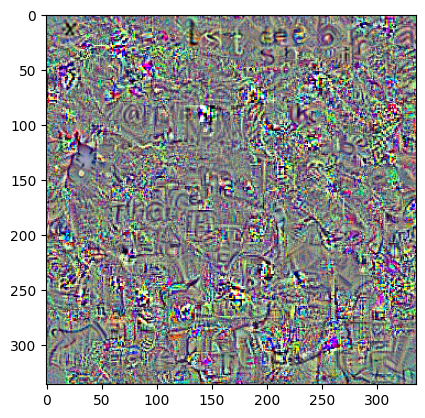

In [83]:
if len(results) == 2:
  results = results[0]

perturbed_image = np.clip(init_input.transpose(0,2,3,1) + results.transpose([0,2,3,1]),0,1)
plt.imshow(perturbed_image[0])